In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import os 
import numpy as np  # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch 
import unicodedata
import random
import sklearn 

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from transformers import (
    DistilBertForSequenceClassification, 
    DistilBertTokenizer, 
    EvalPrediction,
    Trainer, 
    TrainingArguments,
    set_seed
)

# path to distilbert pre-trained model.
PRETRAINED_INPUT_DIR  = '/kaggle/input/bert-pretrained-models-data/distilbert/'

# path to temporary working dir.
WORK_OUTPUT_DIR = '/kaggle/working/'

RANDOM_SEED = 2021
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
for dirname, _, filenames in os.walk('/kaggle/input/commonlitreadabilityprize/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/commonlitreadabilityprize/sample_submission.csv
/kaggle/input/commonlitreadabilityprize/train.csv
/kaggle/input/commonlitreadabilityprize/test.csv


In [2]:
from datetime import datetime 
start_time = datetime.now() 
print('Start Time (hh:mm:ss.ms) {}'.format(start_time))
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
set_seed(RANDOM_SEED)
print("Reproducibility configured.")

Start Time (hh:mm:ss.ms) 2021-08-02 10:03:55.079628
Reproducibility configured.


# Load train and test datasets

In [3]:
train_dataframe = pd.read_csv('datasets/train.csv', doublequote=True)
train_dataframe = train_dataframe.rename(columns={'excerpt':'text', 'target':'label'})
train_dataframe.head()

,id,url_legal,license,text,label,standard_error
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845


In [4]:
train_texts, train_labels = list(train_dataframe['text']), list(train_dataframe['label'])
train_texts, valid_texts, train_labels, valid_labels = train_test_split(train_texts, train_labels, test_size=.25, random_state=RANDOM_SEED)
print("Train set has {} rows, and valid set has {} rows".format(len(train_texts), len(valid_texts)))

Train set has 2125 rows, and valid set has 709 rows


In [5]:
tokenizer = DistilBertTokenizer.from_pretrained(PRETRAINED_INPUT_DIR)
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
valid_encodings = tokenizer(valid_texts, truncation=True, padding=True)
print('Train and valid sets tokenized')

Train and valid sets tokenized


In [6]:
# Create torch dataset
class CommonLitDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels
    
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item['labels'] = torch.tensor(self.labels[idx])
        
        return item
        
    def __len__(self):
        return len(self.encodings["input_ids"])
               
train_dataset = CommonLitDataset(train_encodings, train_labels)
valid_dataset = CommonLitDataset(valid_encodings, valid_labels)
print('Torch dataset created.')

Torch dataset created.


In [7]:
# Define computing metrics Trainer.
from transformers import EarlyStoppingCallback

def model_init():
    return DistilBertForSequenceClassification.from_pretrained(PRETRAINED_INPUT_DIR, num_labels=1, return_dict=True)

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions 
    preds = np.squeeze(preds) 
    return {"rmse": mean_squared_error(y_true=p.label_ids, y_pred=preds, squared=False)}

def make_hp_space(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-5, 1, log=True),
        "num_train_epochs": trial.suggest_int("num_train_epochs", 1, 5),
        "seed": trial.suggest_int("seed", 1, 40),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [4, 8, 16, 32]),
        "per_device_eval_batch_size": trial.suggest_categorical("per_device_eval_batch_size", [4, 8, 16, 32]),
        "weight_decay": trial.suggest_float("weight_decay", 0, 1, step=0.1),
        "warmup_steps": trial.suggest_int("warmup_steps", 0, 500, step=100),
        "adam_epsilon": trial.suggest_float("adam_epsilon", 1e-10, 1e-6, log=True)
    }

def get_objective_metric(metrics):
    return metrics['eval_rmse']

# Define Trainer parameters
os.environ["WANDB_DISABLED"] = "true"
batch_size = 16
training_args = TrainingArguments(
    # The output directory where the model predictions 
    # and checkpoints will be written.
    output_dir='/kaggle/working/output',
    
    # Overwrite the content of the output directory.
    overwrite_output_dir=True,
    
    # Whether to run training or not.
    do_train=True,
    
    # Whether to run evoluation on the dev or not.
    do_eval=True,
    
    # Batch size GPU/TPU core/CPU for training
    per_device_train_batch_size=batch_size,
    
    # Batch size GPU/TPU core/CPU for evaluation
    per_device_eval_batch_size=batch_size * 4, #batch_size * 2, 
    
    # Evaluation strategy to adopt during training.
    evaluation_strategy="steps",
    
    # How often to show logs.
    logging_steps=100,
    
    # Number of update steps between two 
    # evaluations if evaluation_strategy="steps".
    # Will default to the same value as l
    # logging_steps if not set.
    eval_steps=100,
    
    # Set prediction loss to 'True' in order to 
    # return loss for perplexity calculation
    # prediction_loss_only=True,
    
    # The initial learning rate for Adam.
    # Default to 5e-5
    learning_rate= 2.5e-5,
    
    # The weigth decay to apply (if not zero)
    weight_decay=1.5, #1.0, #0.0,
    
    # Epsilon for Adam optimizer,
    # Defaults to 1e-8
    adam_epsilon=3.890824499297403e-10, #1e-8,
    
    # Maximum gradient norm (for gradient 
    # clipping). Defaults to 0.
    max_grad_norm=0,
    
    # Total number of training epochs to perform 
    # (if not an integer, will perform the 
    # decimal part percents of
    # the last epoch before stopping training).
    num_train_epochs=5, #3,

    # Number of updates steps before two checkpoint saves. 
    # Defaults to 500
    # save_steps=-1,
    
    # Number of steps used for a linear warmup from 0 to learning_rate.
    warmup_steps=500, 
    
    # Use in conjunction with load_best_model_at_end to specify 
    # the metric to use to compare two different models.
    metric_for_best_model="eval_rmse",
    
    # Whether or not to load the best model found during training 
    # at the end of training.
    load_best_model_at_end=True,
    
    # Use in conjunction with load_best_model_at_end and metric_for_best_model 
    # to specify if better models should have a greater metric or not. 
    greater_is_better=False,
    
    # TensorBoard log directory.
    logging_dir='/kaggle/working/logs',
    
    # Random seed that will be set at the beginning of training.
    seed=18, #0,
    
    # The list of integrations to report the results and logs to.
    report_to=None
)

print('Train arguments set up.')

Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Train arguments set up.


In [8]:
print("Loading `Trainer`...")
trainer = Trainer(
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    compute_metrics=compute_metrics,
    model_init=model_init,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
    tokenizer=tokenizer
)
print("`Trainer` loaded.")

Loading `Trainer`...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at /kaggle/input/bert-pretrained-models-data/distilbert/ and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'classifier.bias', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


`Trainer` loaded.


In [9]:
# Train pre-trained model
if training_args.do_train:
    train_results = trainer.train()
    display(train_results)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at /kaggle/input/bert-pretrained-models-data/distilbert/ and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'classifier.bias', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Rmse,Runtime,Samples Per Second
100,1.547000,0.880095,0.938134,3.179700,222.980000
200,0.544000,0.353019,0.594154,3.176500,223.199000
300,0.329100,0.365839,0.604847,3.174700,223.329000
400,0.279700,0.281096,0.530184,3.198100,221.693000
500,0.174200,0.271636,0.521187,3.169100,223.722000
600,0.141200,0.262859,0.512698,3.177000,223.167000


TrainOutput(global_step=665, training_loss=0.463424073126083, metrics={'train_runtime': 250.9362, 'train_samples_per_second': 2.65, 'total_flos': 1340256519217500.0, 'epoch': 5.0, 'init_mem_cpu_alloc_delta': 2265829376, 'init_mem_gpu_alloc_delta': 268950016, 'init_mem_cpu_peaked_delta': 300285952, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 473534464, 'train_mem_gpu_alloc_delta': 1087668224, 'train_mem_cpu_peaked_delta': 157048832, 'train_mem_gpu_peaked_delta': 2814502912})

In [10]:
import math
# Keep track of train models and evaluate loss.
loss_history = {'train_loss':[], 'eval_loss':[]}

# Keep track of train and evaluate perplexity
perplexity_history = {'train_perplexity':[], 'eval_perplexity':[]}
for log_history in trainer.state.log_history:
    if 'loss' in log_history.keys():
        loss_history['train_loss'].append(log_history['loss'])
        perplexity_history['train_perplexity'].append(math.exp(log_history['loss']))
        
    elif 'eval_loss' in log_history.keys():
        loss_history['eval_loss'].append(log_history['eval_loss'])
        perplexity_history['eval_perplexity'].append(math.exp(log_history['eval_loss']))

<AxesSubplot:>

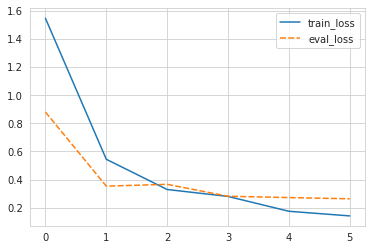

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
sns.lineplot(data=loss_history)

<AxesSubplot:>

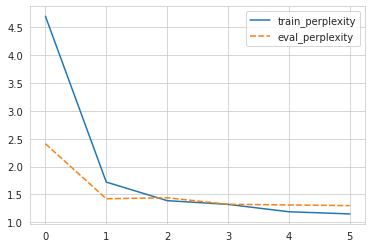

In [12]:
sns.set_style("whitegrid")
sns.lineplot(data=perplexity_history)

In [13]:
if training_args.do_eval:    
    eval_output = trainer.evaluate()
    perplexity = math.exp(eval_output['eval_loss'])
    rmse = eval_output['eval_rmse']
    print('\nEvaluate Perplexity: {:3,.3f}'.format(perplexity))
    print('Evaluate RMSE: {:3,.3f}'.format(rmse))
else:
    print('No evaluation needed. No evaluation data provided, `do_eval=False`!')


Evaluate Perplexity: 1.301
Evaluate RMSE: 0.513


In [14]:
# Load test data
test_dataframe = pd.read_csv('/kaggle/input/commonlitreadabilityprize/test.csv', doublequote=True)
test_texts = test_dataframe.rename(columns={'excerpt':'text'})['text'].to_list()
test_encodings  = tokenizer(test_texts, truncation=True, padding=True)

# Create torch dataset
test_dataset  = CommonLitDataset(test_encodings)

y_pred=trainer.predict(test_dataset)

print('Prediction done')

Prediction done


In [15]:
# Save test predictions to file
np.set_printoptions(precision=1)
output = pd.DataFrame({'id': test_dataframe['id'],
                       'target': y_pred.predictions[:, 0]})
output.to_csv('submission.csv', index=False, float_format='%.1f')
print(output)
print('Test evaluation submitted.')

          id    target
0  c0f722661 -0.396497
1  f0953f0a5 -0.467817
2  0df072751 -0.275873
3  04caf4e0c -2.176110
4  0e63f8bea -1.912005
5  12537fe78 -1.278331
6  965e592c0  0.398807
Test evaluation submitted.


In [16]:
time_elapsed = datetime.now() - start_time 
print('Time elapsed (hh:mm:ss.ms) {}'.format(time_elapsed))

Time elapsed (hh:mm:ss.ms) 0:04:53.829008
